# 2 Solution - Q Network Solution Tensorflow- FrozenLake
The main difference with the first solution is that here we will use a Neural Network instead of an array for the State - Action reward evaluation Q.

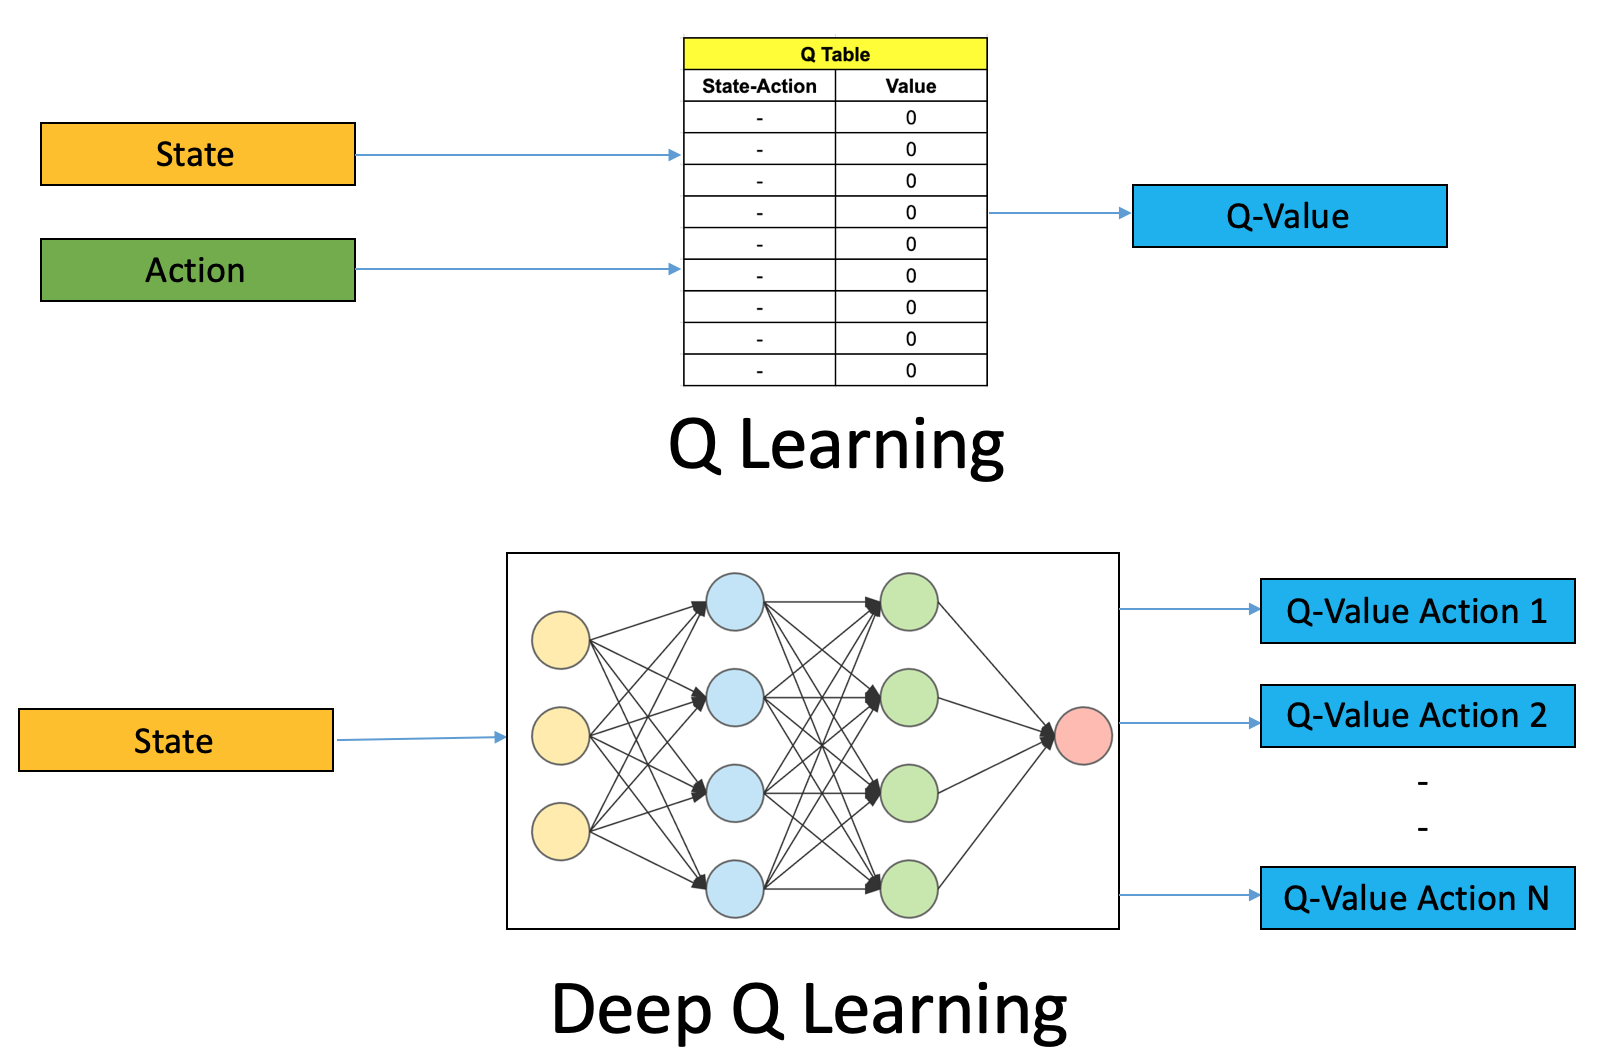

Full desclaimer it is obvius that for this simple problem its an overkill to use tensorflow and neural networks the 1 solution enough.

The main difference with the original solution here is that, instead of keeping all the information and updating the rewards from an array of all possible state action combinations. Here we have a Neural Network that learn how to apply a reward to every state for all possible actions.

This is an amazing approach especially for problems that dont have a deterministic number of possible states, for example with games that your only input is the frame of the game 

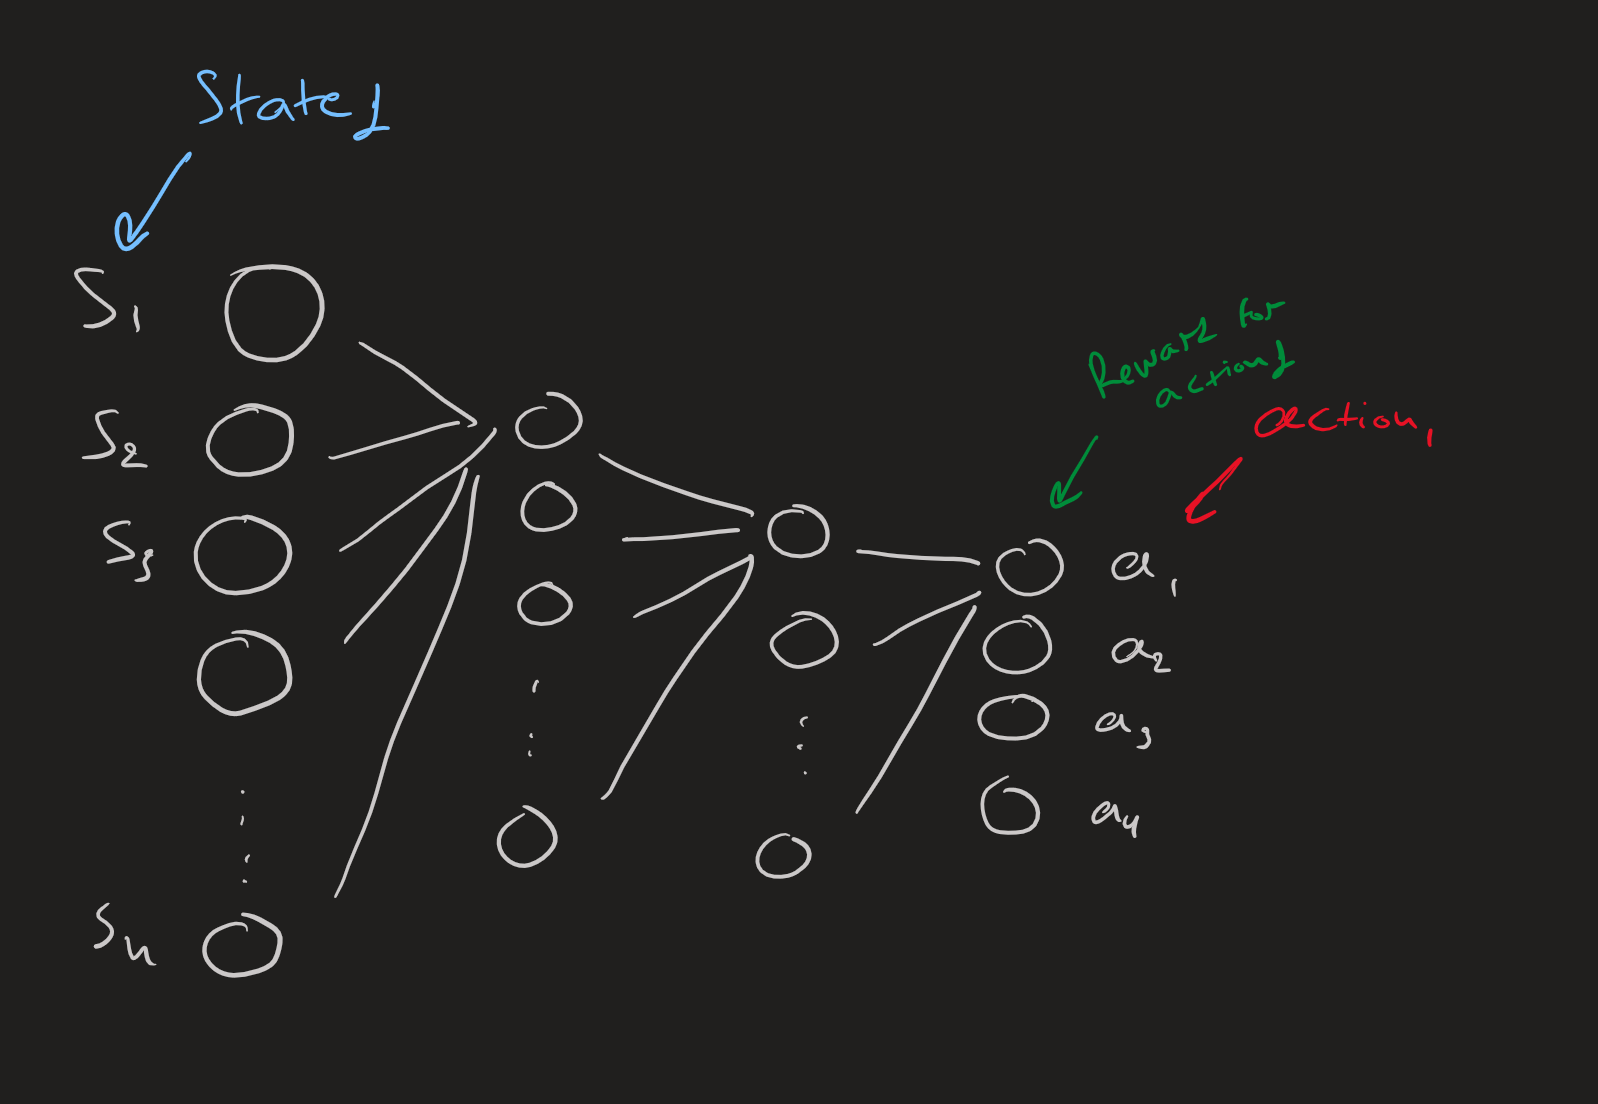

Something that we dont do here in order to make the solution simpler is to use two separate networks to calcualte the original reward and action and then to caluclate the subsequent reward and action. Here we use 1 network for everything but most of the time we use two networks.

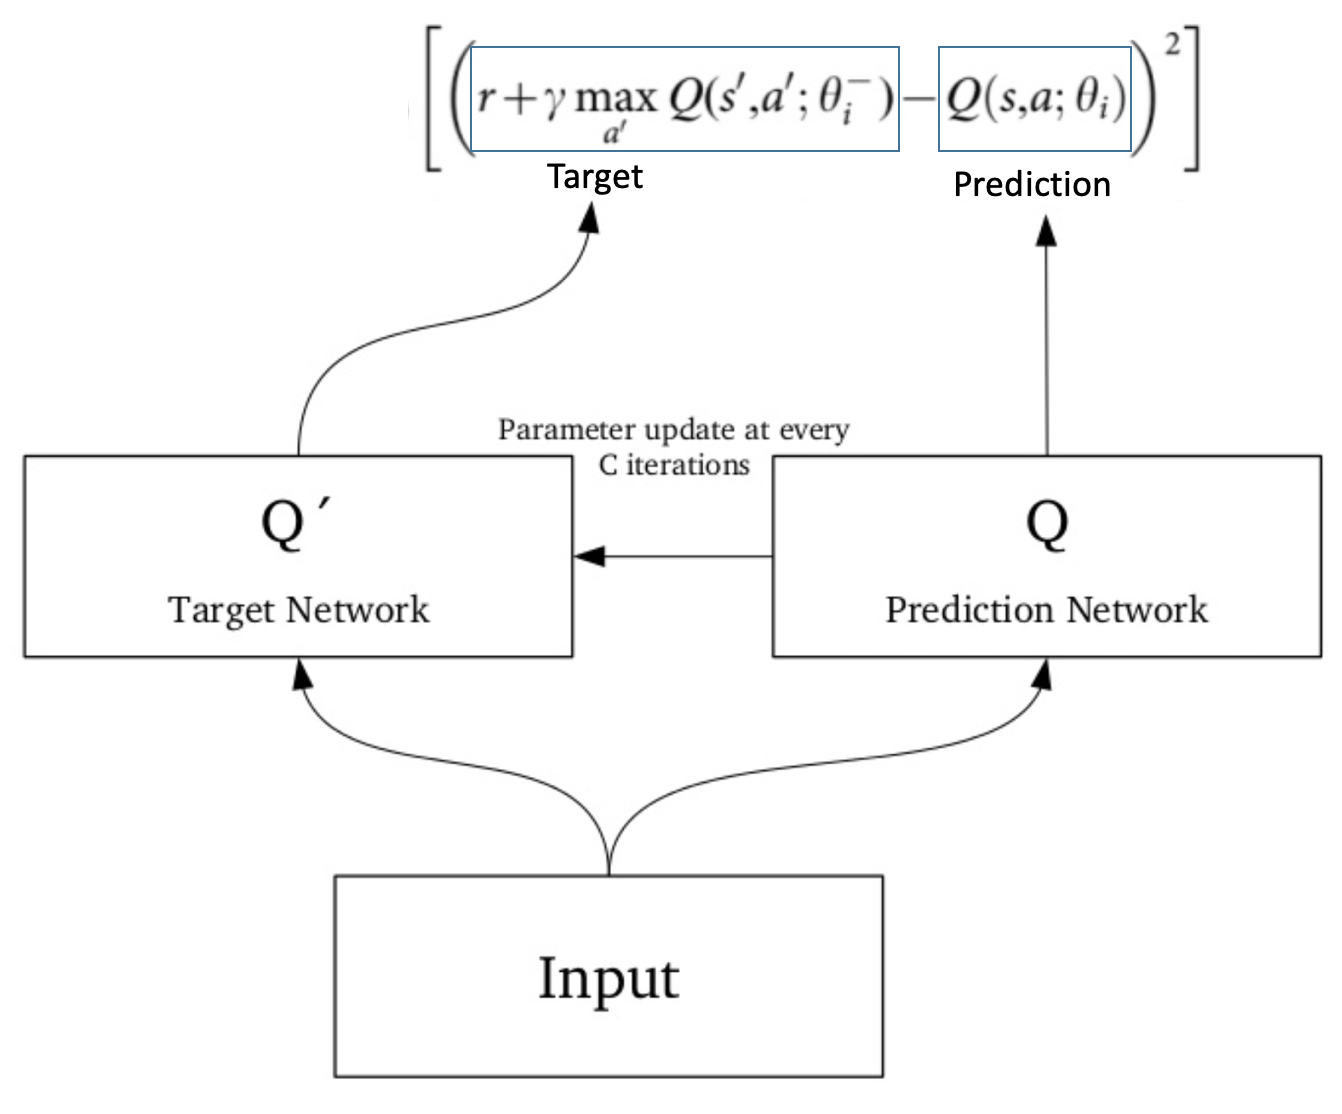

In [ ]:
import random
import time
from IPython.display import clear_output
import gym
from gym import wrappers 
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf

env = gym.make("FrozenLake8x8-v0")
env = wrappers.Monitor(env, '/tmp/frozenlake-qlearning', force=True)

prev_state = env.reset() 

# Initialize Parameters

In [ ]:
lr = 0.1 
gamma = 0.99 
count_episodes = 1200
# count_episodes = 5000
episodes = 0 
episode_t = 0
e = 1
# e = 0.1 

# Tensorflow Initialization
In tensorflow and in general in every deep learning framework you need to initialize the network, here we are initializing the simplest network that we can possibly initialize with only:
1.  1 input which is the state
2.  64 neurons in the middle 
3.  that are translated on 4 final neurons - actions
4.  for comparing and using we get the max reward "argmax(out)"

In [ ]:
  def createModel(num_neur):
  x = tf.placeholder(shape=[1, num_neur], dtype=tf.float32)
  W = tf.Variable(tf.random_uniform([num_neur, 4], 0, 0.1))
  out = tf.matmul(x, W)
  act = tf.argmax(out, 1)

  return x,out,act

IndentationError: ignored

# Loss and training
Here again just to prove the concept we are using the simplest possible techniques with the GradienDescenOptimizer and the reduce sum

Of course we can also use a complecated neural network in order to see how the system will react 

In [ ]:
def lossTraining(out,lr):
  t = tf.placeholder(shape=[1, 4], dtype = tf.float32)
  loss = tf.reduce_sum(tf.square(t - out))
  train_step = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(loss)

  return t,loss,train_step

### Explanation 1 Solution about Action Random 

In [ ]:
def nextActionRandomOrMax(act,out,prev_state,env,e):
  action, qvalues = sess.run([act, out], feed_dict={x: np.identity(64)[prev_state:prev_state + 1]})
  # action, qvalues = sess.run([act, out], feed_dict={x: np.identity(16)[prev_state:prev_state + 1]})
  if e > (np.random.rand(1)): 
  # if e > (np.random.rand(1)): 
      action[0] = env.action_space.sample()
  next_state, rew, done, _ = env.step(action[0])

  return next_state, rew, done,qvalues,action


In [ ]:
def findTargetQ(out,next_state):
  qnext_values = sess.run([out], feed_dict={x: np.identity(64)[next_state:next_state + 1]})
  # qnext_values = sess.run([out], feed_dict={x: np.identity(16)[next_state:next_state + 1]})
  max_q = np.max(qnext_values)
  targetq = qvalues 

  return targetq,max_q

## Details on the 1 Solution about Exploration Decay

In [ ]:
def explorationDecay (env,episode): 
  max_exploration_rate= 1
  min_exploration_rate = 0.01 # Even when we worked for a long time we still want to do a little bit of exploration
  exploration_decay_rate =0.0015 # The more we learn the less we will explore

  # ---------------- Exploration rate decay 2 -----------------------
  exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate)*np.exp(-exploration_decay_rate*episode)
  # ---------------- Exploration rate decay 2 -----------------------

  return exploration_rate

# Main steps that every Reinforcment Learning algorithm need to have 


1.   Reset the environment
2.   Create the Model
3.   Create the LossModel Training
4.   Initialize the tensorflow variables
5.   Find the new action and use it randomly or from best action
6.   Find the targetQ by using the new state that we just calcuated (this will be used on the Bellman function!
7.   Caluclate the loss throw Bellman function
8.   Train the neural netowrk in order to improve the prediction for the next time
9.   Repeat



In [ ]:
prev_state = env.reset()

x,out,act = createModel(64)
# x,out,act = createModel(16)

t,loss,train_step = lossTraining(out,lr)

#  ---------------- start session ---------------- 
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
#  ---------------- start session ---------------- 

testEvery = 100
countTestEvery = 0
correctAnswers = [0]
falseAnswers = [0]
correctAndFalseAnsweresCount = 0


rewardEveryEpisode = []
while episodes < count_episodes: 
    episode_t += 1
    
    next_state, rew, done,qvalues,action = nextActionRandomOrMax(act,out,prev_state,env,e)

    if (done==True and rew==0):
      rew = -0.5

    targetq,max_q = findTargetQ(out,next_state)
    
    # --------------------- Update Model ---------------------
    targetq[0, action[0]] = rew + gamma * max_q
    sess.run([train_step], feed_dict={x: np.identity(64)[prev_state:prev_state + 1], t: targetq})
    # sess.run([train_step], feed_dict={x: np.identity(16)[prev_state:prev_state + 1], t: targetq})
    # --------------------- Update Model ---------------------


    prev_state = next_state

    # episode finished
    if done: 
        episodes += 1
        # decrease noise as number of episodes increases
        e = explorationDecay (env,episodes)
        prev_state = env.reset()
        print ("episode %d out of %d"% (episodes,count_episodes) )
        rewardEveryEpisode.append(rew)
        episode_t = 0

        # ----------------------- Persentage of Correct answeres ----------------------- 
        if (countTestEvery<testEvery):
            countTestEvery += 1
            if (rew==1):
                correctAnswers[correctAndFalseAnsweresCount] += 1
            elif (rew==-0.5):
                falseAnswers[correctAndFalseAnsweresCount] += 1
        else:
            countTestEvery = 0
            correctAndFalseAnsweresCount += 1
            if (rew==1):
                correctAnswers.append(1)
                falseAnswers.append(0)
            elif (rew==-0.5):
                correctAnswers.append(0)
                falseAnswers.append(1)
                
        # ----------------------- Persentage of Correct answeres -----------------------

episode 1 out of 4000
episode 2 out of 4000
episode 3 out of 4000
episode 4 out of 4000
episode 5 out of 4000
episode 6 out of 4000
episode 7 out of 4000
episode 8 out of 4000
episode 9 out of 4000
episode 10 out of 4000
episode 11 out of 4000
episode 12 out of 4000
episode 13 out of 4000
episode 14 out of 4000
episode 15 out of 4000
episode 16 out of 4000
episode 17 out of 4000
episode 18 out of 4000
episode 19 out of 4000
episode 20 out of 4000
episode 21 out of 4000
episode 22 out of 4000
episode 23 out of 4000
episode 24 out of 4000
episode 25 out of 4000
episode 26 out of 4000
episode 27 out of 4000
episode 28 out of 4000
episode 29 out of 4000
episode 30 out of 4000
episode 31 out of 4000
episode 32 out of 4000
episode 33 out of 4000
episode 34 out of 4000
episode 35 out of 4000
episode 36 out of 4000
episode 37 out of 4000
episode 38 out of 4000
episode 39 out of 4000
episode 40 out of 4000
episode 41 out of 4000
episode 42 out of 4000
episode 43 out of 4000
episode 44 out of 40

# Persentage of average reward per thousand

In [ ]:
averageRewardTh = np.zeros((4,1))
for i in range(len(rewardEveryEpisode)):
    averageRewardTh[int(i/1000)] = averageRewardTh[int(i/1000)] + rewardEveryEpisode[i]
    
print(averageRewardTh/1000*100)

[[-39.5 ]
 [  8.35]
 [ 37.9 ]
 [ 49.  ]]


# Persentage of Correct answeres

In [ ]:
for i in range(len(correctAnswers)):
    print("Phase ",i,"  Persentage Correct to Wrong Results = ",round((correctAnswers[i]/(correctAnswers[i]+falseAnswers[i]))*100)," number Correct = ",correctAnswers[i]," Number False = ",falseAnswers[i])


Phase  0   Persentage Correct to Wrong Results =  0  number Correct =  0  Number False =  100
Phase  1   Persentage Correct to Wrong Results =  0  number Correct =  0  Number False =  101
Phase  2   Persentage Correct to Wrong Results =  1  number Correct =  1  Number False =  100
Phase  3   Persentage Correct to Wrong Results =  2  number Correct =  2  Number False =  99
Phase  4   Persentage Correct to Wrong Results =  0  number Correct =  0  Number False =  101
Phase  5   Persentage Correct to Wrong Results =  6  number Correct =  6  Number False =  95
Phase  6   Persentage Correct to Wrong Results =  14  number Correct =  14  Number False =  87
Phase  7   Persentage Correct to Wrong Results =  15  number Correct =  15  Number False =  86
Phase  8   Persentage Correct to Wrong Results =  18  number Correct =  18  Number False =  83
Phase  9   Persentage Correct to Wrong Results =  14  number Correct =  14  Number False =  87
Phase  10   Persentage Correct to Wrong Results =  21  num

# Persentage Win Lose Current Training


In [ ]:
numberGames = 50
numberCorrect = 0
stepEpisode = 100
for episode in range(numberGames):
    try:
      state = env.reset()
    except:
      a = 2

    done = False
    
    for step in range(stepEpisode):
        
        action, qvalues = sess.run([act, out], feed_dict={x: np.identity(64)[prev_state:prev_state + 1]})
        # action, qvalues = sess.run([act, out], feed_dict={x: np.identity(16)[prev_state:prev_state + 1]})
        new_state,reward,done,info = env.step(action[0])
        
        if done: # If we are done ( foudn the goal or a fail)
            if reward ==1:
                numberCorrect = numberCorrect + 1
            break
        
        prev_state = new_state
        


print("Persentage of win games = ",(numberCorrect/numberGames)*100,"(Win Games, Lose Games) = ",numberCorrect,numberGames - numberCorrect)
                

Persentage of win games =  38.0 (Win Games, Lose Games) =  19 31


# Play the Game

In [ ]:
max_steps_per_episode = 100
for episode in range(3):
    try:
      state = env.reset()
    except:
      a = 2
    done = False
    print("***Episode ",episode+1,"***")
    time.sleep(1)
    
    for step in range(max_steps_per_episode):
        clear_output(wait=True)
        env.render()
        time.sleep(0.04)

        action, qvalues = sess.run([act, out], feed_dict={x: np.identity(64)[prev_state:prev_state + 1]})
        # action, qvalues = sess.run([act, out], feed_dict={x: np.identity(16)[prev_state:prev_state + 1]})
        new_state,reward,done,info = env.step(action[0])
        
        if done:
            clear_output(wait=True)
            env.render()
            if reward ==1:
                print("*** Reached the Goal!***")
                time.sleep(1)
            else:
                print("*** Fell through a hole!***")
                time.sleep(1)
            clear_output(wait=True)
            break
        
        prev_state = new_state
        
env.close()
                

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


# Future Improvements 

1.   Use two networks instead of 1
2.   More evaluation metrics


*   Count steps to find the correct result
*   Count the unecesary movements 
*   etc.


2.   Test for larger arrays 
3.   Check different hyperparameters for optimization of resutls
4.   More time training
5.   Test other Neural Networks
6.   Test the same algorithms on other problems

